## Setup enviroment

In [1]:
import os
import gc
import pandas as pd
import numpy as np
from catboost import CatBoostClassifier
from sklearn.metrics import log_loss, roc_auc_score, average_precision_score, brier_score_loss, precision_recall_curve
from sklearn.calibration import calibration_curve, CalibratedClassifierCV
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import sys
sys.path.append(r'C:\Users\jeanr\Documents\projetos\classificacao\lending-club\global')
from util import *
import optuna
import arfs.feature_selection.allrelevant as arfsgroot
import shap
import json
import joblib
from venn_abers import VennAbersCalibrator

sns.set(style='whitegrid')

c:\Users\jeanr\Documents\projetos\classificacao\lending-club\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Read train, validation and calibration data

In [2]:
train_df = pd.read_parquet('../data/processed/abt_train.parquet')
validation_df = pd.read_parquet('../data/processed/abt_validation.parquet')
calibration_df = pd.read_parquet('../data/processed/abt_calibration.parquet')
test_df = pd.read_parquet('../data/processed/abt_test.parquet')

In [3]:
categorical_column_names = train_df.select_dtypes(include=['category']).columns
categorical_column_names

Index(['grade', 'sub_grade', 'emp_length', 'home_ownership',
       'verification_status', 'application_type'],
      dtype='object')

In [4]:
cat_features = ['grade', 'sub_grade', 'emp_length', 'home_ownership',
       'verification_status', 'application_type']

## Train, Validation, Test Split

In [5]:
target = 'default'

# Input variables and Target dataframes
X_train, y_train= train_df.drop(target, axis=1), train_df.loc[:, target]
X_validation, y_validation= validation_df.drop(target, axis=1), validation_df.loc[:, target]
X_calibration, y_calibration= calibration_df.drop(target, axis=1), calibration_df.loc[:, target]

# Freeing memory
train_df = None
calibration_df = None
validation_df = None
gc.collect()

print('Train Shape: ', X_train.shape, y_train.shape)
print('Validation shape: ', X_validation.shape, y_validation.shape)
print('Calibration shape: ', X_calibration.shape, y_calibration.shape)

Train Shape:  (88744, 100) (88744,)
Validation shape:  (264688, 100) (264688,)
Calibration shape:  (66173, 100) (66173,)


In [6]:
print('Train Churn Values count:\n', y_train.value_counts())
print(y_train.value_counts(normalize=True))

Train Churn Values count:
 default
0.0    72659
1.0    16085
Name: count, dtype: int64
default
0.0    0.818748
1.0    0.181252
Name: proportion, dtype: float64


In [7]:
print('Validation Churn Values count:\n', y_validation.value_counts())
print(y_validation.value_counts(normalize=True))

Validation Churn Values count:
 default
0.0    211999
1.0     52689
Name: count, dtype: int64
default
0.0    0.800939
1.0    0.199061
Name: proportion, dtype: float64


In [8]:
print('Calibration Churn Values count:\n', y_calibration.value_counts())
print(y_calibration.value_counts(normalize=True))

Calibration Churn Values count:
 default
0.0    53000
1.0    13173
Name: count, dtype: int64
default
0.0    0.800931
1.0    0.199069
Name: proportion, dtype: float64


## Train a Vanilla Baseline CatBoost Model

In [9]:
# Using PRAUC Use Weights False to not inflat the PRAUC metric
baseline_params = {
    'iterations': 1000,
    'auto_class_weights': 'Balanced',
    'eval_metric': 'PRAUC:use_weights=false',
    'cat_features': cat_features,
    'verbose': True,
    'random_seed': 55,
    'max_depth': 8,
    'colsample_bylevel': 0.8,
    'subsample': 0.7,
    'learning_rate': 0.02,
    'early_stopping_rounds': 100
}
model = CatBoostClassifier(**baseline_params)

print('Traning the model...')
model.fit(X_train, y_train, eval_set=(X_validation, y_validation), early_stopping_rounds=100)

print('Evaluating the model...')
y_pred_baseline = model.predict_proba(X_validation)[:, 1]

Traning the model...
0:	learn: 0.3191068	test: 0.3404459	best: 0.3404459 (0)	total: 314ms	remaining: 5m 13s
1:	learn: 0.3286628	test: 0.3346274	best: 0.3404459 (0)	total: 477ms	remaining: 3m 58s
2:	learn: 0.3259141	test: 0.3397506	best: 0.3404459 (0)	total: 568ms	remaining: 3m 8s
3:	learn: 0.3292071	test: 0.3389530	best: 0.3404459 (0)	total: 753ms	remaining: 3m 7s
4:	learn: 0.3304874	test: 0.3459000	best: 0.3459000 (4)	total: 891ms	remaining: 2m 57s
5:	learn: 0.3312986	test: 0.3494180	best: 0.3494180 (5)	total: 1.03s	remaining: 2m 50s
6:	learn: 0.3329610	test: 0.3480515	best: 0.3494180 (5)	total: 1.19s	remaining: 2m 48s
7:	learn: 0.3339987	test: 0.3474849	best: 0.3494180 (5)	total: 1.37s	remaining: 2m 50s
8:	learn: 0.3343901	test: 0.3502884	best: 0.3502884 (8)	total: 1.54s	remaining: 2m 49s
9:	learn: 0.3348550	test: 0.3517531	best: 0.3517531 (9)	total: 1.71s	remaining: 2m 49s
10:	learn: 0.3353907	test: 0.3522918	best: 0.3522918 (10)	total: 1.87s	remaining: 2m 48s
11:	learn: 0.3363877	t

In [10]:
# Metrics Report
clf_metric_report(y_pred_baseline, y_validation)

Evaluating the model...
ROC AUC: 0.7075410527161095
Brier Score: 0.22000429047434117
Average Precision: 0.3691383629014476
Log Loss: 0.6272075914622884


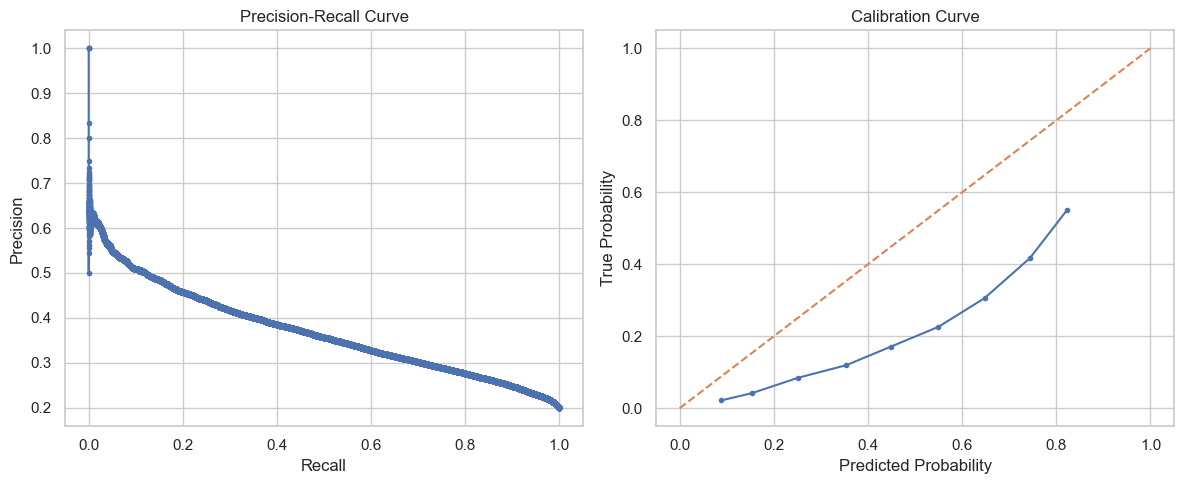

In [11]:
# PR Curve and Calibration curve
plot_pr_calib_curve(y_pred_baseline, y_validation)

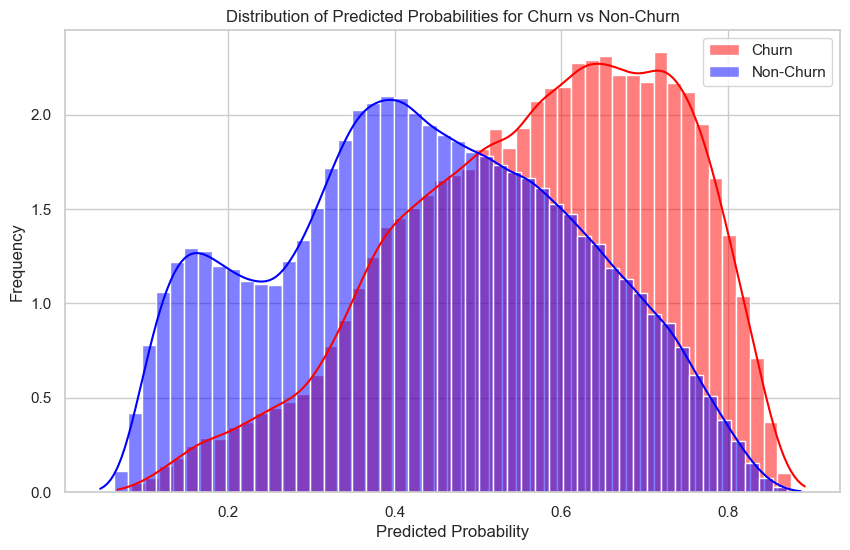

In [12]:
# Distribution of predicted probabilities
plot_dis_probs(y_pred_baseline, y_validation)

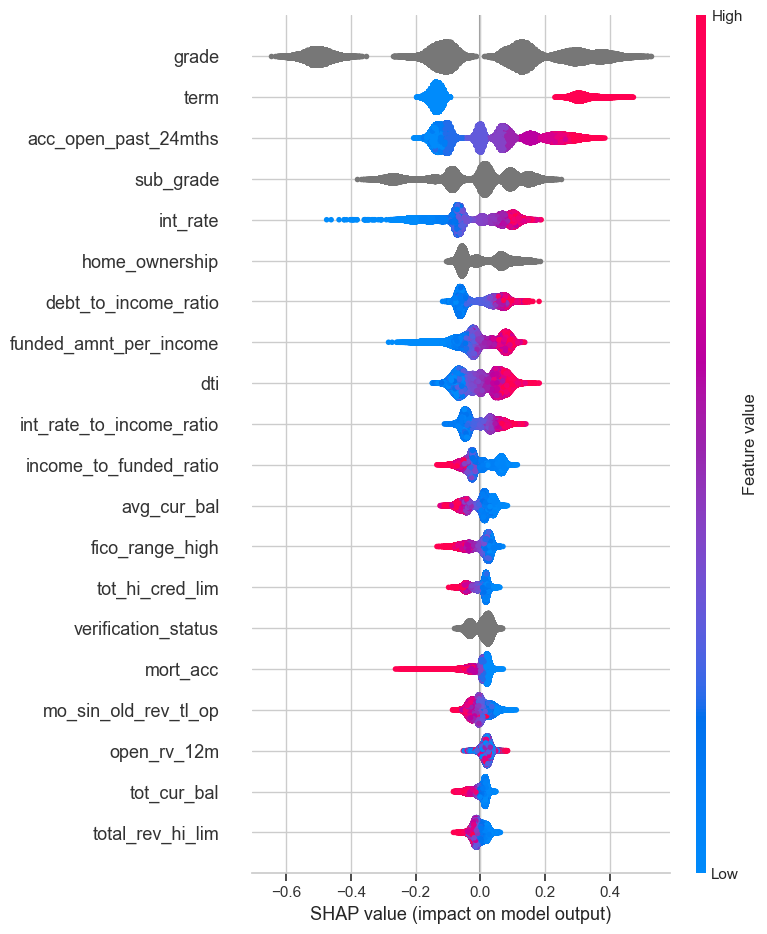

In [13]:
# SHAP Values
shap_explainer = shap.Explainer(model)
shap_values = shap_explainer(X_validation)
#shap.summary_plot(shap_values, X_validation, plot_type='dot', max_display=25)
shap.summary_plot(shap_values, X_validation)

## Feature Selection with Boruta

In [14]:
selected_features = None

In [15]:
# untuned, this is just a set of "reasonable defaults" to get better feature selection
feat_selection_params = {
    'random_strength': 1,
    'learning_rate': 0.02,
    'max_depth': 8,
    'colsample_bylevel': 0.8,
    'subsample': 0.7,
    'random_seed': 42,
    'auto_class_weights': 'Balanced',
    #'cat_features': cat_features,
    'verbose': False 
}

''''
Iteration: 	1 / 10
Confirmed: 	37
Tentative: 	47
Rejected: 	66
'''

model_for_feat_selection = CatBoostClassifier(**feat_selection_params) 

feat_selector = arfsgroot.Leshy(
    model_for_feat_selection, n_estimators=150, verbose=1, max_iter=10, random_state=55, importance="fastshap",
)

feat_selector.fit(X_train.drop(cat_features, axis=1), y_train)

c:\Users\jeanr\Documents\projetos\classificacao\lending-club\.venv\Lib\site-packages\arfs\feature_selection\allrelevant.py:325: UserWarning: fasttreeshap is not installed. Fallback to shap.
  warnings.warn("fasttreeshap is not installed. Fallback to shap.")
c:\Users\jeanr\Documents\projetos\classificacao\lending-club\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
Leshy iteration: 100%|██████████| 10/10 [01:30<00:00,  9.03s/it]



Leshy finished running using shap var. imp.

Iteration: 	1 / 10
Confirmed: 	38
Tentative: 	9
Rejected: 	47
All relevant predictors selected in 00:01:30.48


Leshy(estimator=<catboost.core.CatBoostClassifier object at 0x0000027617966090>,
      max_iter=10, n_estimators=150,
      random_state=RandomState(MT19937) at 0x27615D47840, verbose=1)

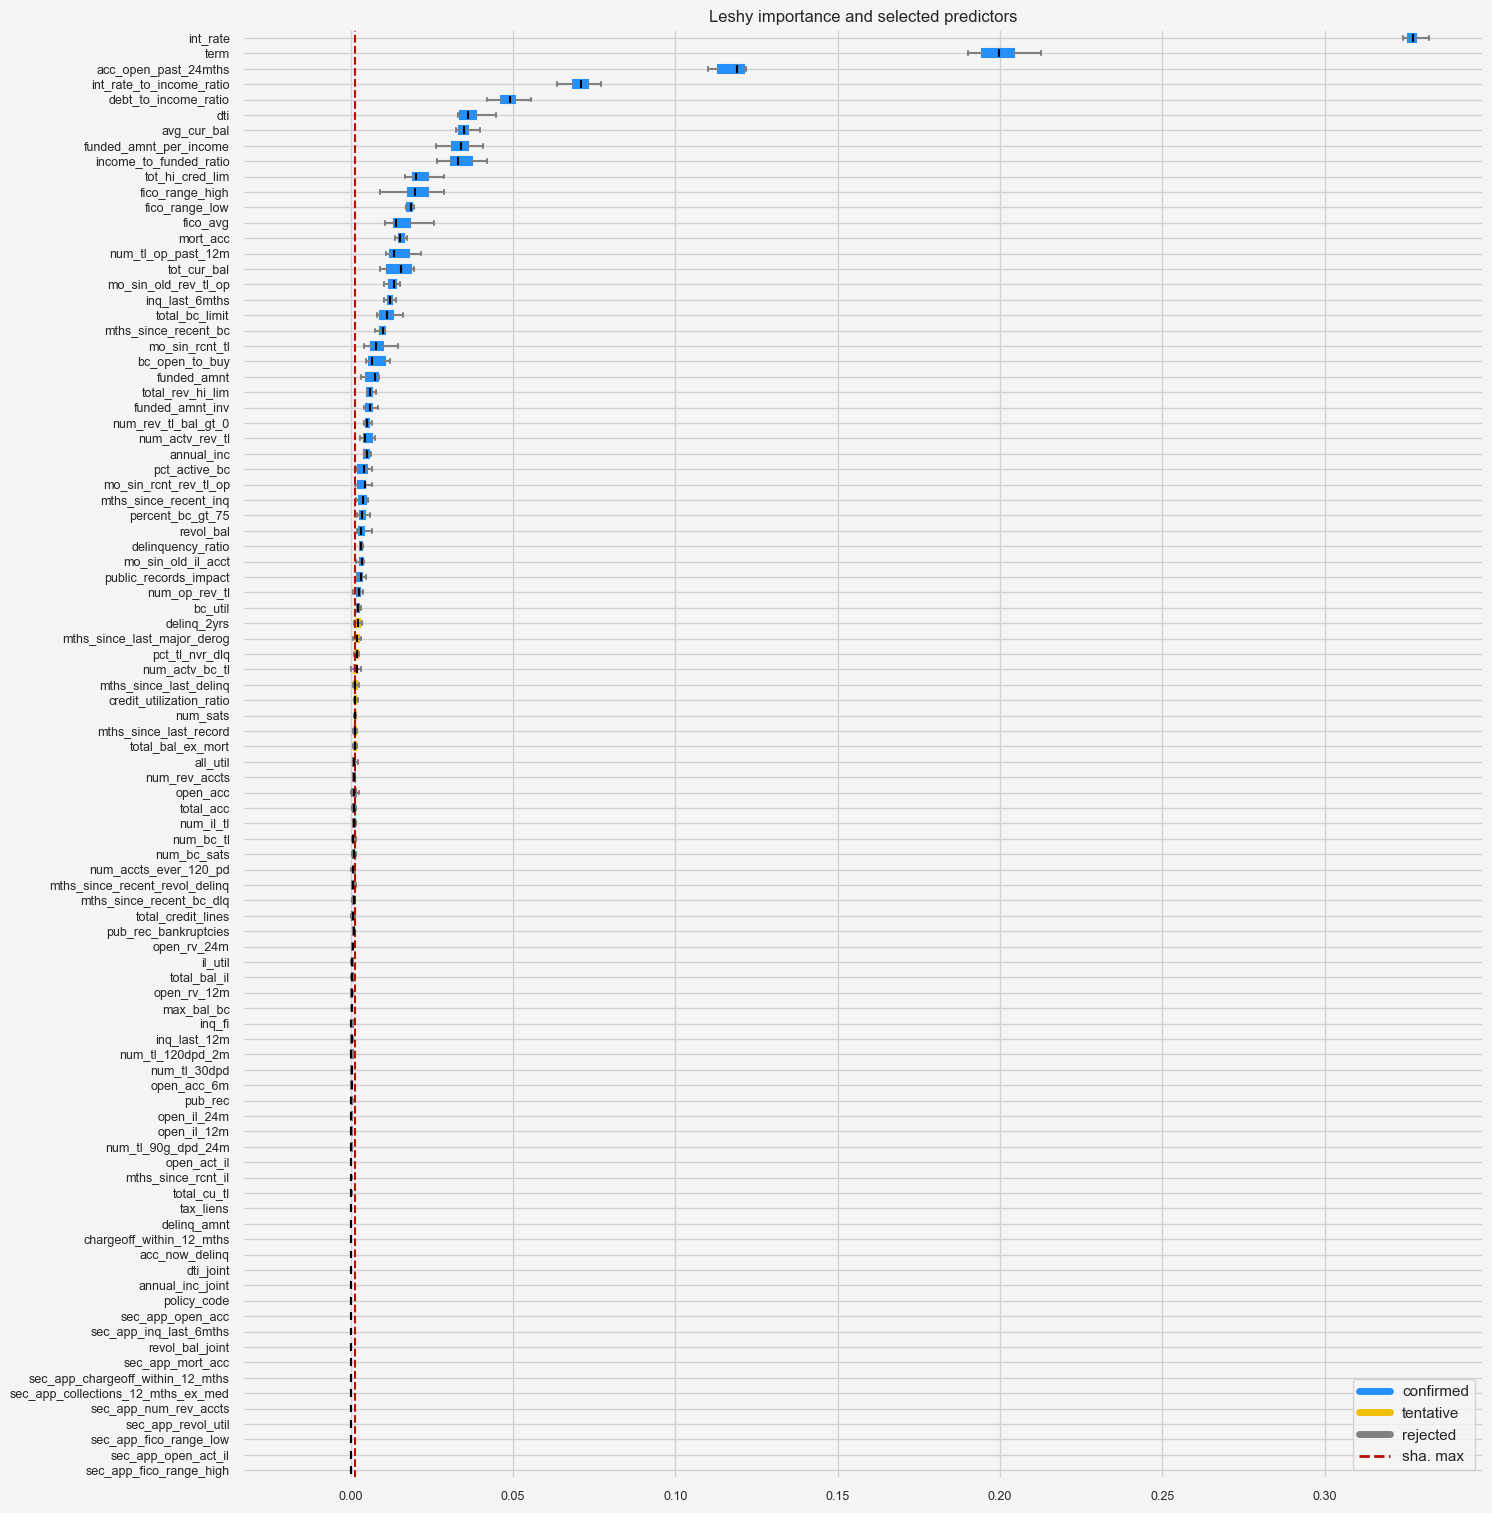

In [16]:
_ = feat_selector.plot_importance()

In [17]:
selected_features = feat_selector.get_feature_names_out().tolist() + cat_features

# Save the selected features
with open('../artifacts/selected_features_list.json', 'w') as f:
    json.dump(selected_features, f)

In [18]:
print(f"The selected features: {selected_features}")

The selected features: ['funded_amnt', 'funded_amnt_inv', 'term', 'int_rate', 'annual_inc', 'dti', 'fico_range_low', 'fico_range_high', 'inq_last_6mths', 'revol_bal', 'tot_cur_bal', 'total_rev_hi_lim', 'acc_open_past_24mths', 'avg_cur_bal', 'bc_open_to_buy', 'bc_util', 'mo_sin_old_il_acct', 'mo_sin_old_rev_tl_op', 'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl', 'mort_acc', 'mths_since_recent_bc', 'mths_since_recent_inq', 'num_actv_rev_tl', 'num_op_rev_tl', 'num_rev_tl_bal_gt_0', 'num_tl_op_past_12m', 'percent_bc_gt_75', 'tot_hi_cred_lim', 'total_bc_limit', 'income_to_funded_ratio', 'debt_to_income_ratio', 'funded_amnt_per_income', 'fico_avg', 'delinquency_ratio', 'int_rate_to_income_ratio', 'public_records_impact', 'pct_active_bc', 'grade', 'sub_grade', 'emp_length', 'home_ownership', 'verification_status', 'application_type']


## Train a Vanilla CatBoost Model with Selected Features

In [19]:
if selected_features == None:
    with open('../artifacts/selected_features_list.json', 'r') as f:
        selected_features = json.load(f)

model_selected = CatBoostClassifier(**baseline_params)
model_selected.fit(X_train[selected_features], y_train, eval_set=(X_validation[selected_features], y_validation), early_stopping_rounds=200, verbose=True)

y_pred_selected = model_selected.predict_proba(X_validation[selected_features])[:, 1]

0:	learn: 0.3220402	test: 0.3429977	best: 0.3429977 (0)	total: 176ms	remaining: 2m 55s
1:	learn: 0.3226616	test: 0.3485635	best: 0.3485635 (1)	total: 343ms	remaining: 2m 51s
2:	learn: 0.3268906	test: 0.3527548	best: 0.3527548 (2)	total: 509ms	remaining: 2m 49s
3:	learn: 0.3259383	test: 0.3534289	best: 0.3534289 (3)	total: 619ms	remaining: 2m 34s
4:	learn: 0.3290412	test: 0.3558028	best: 0.3558028 (4)	total: 770ms	remaining: 2m 33s
5:	learn: 0.3322290	test: 0.3580886	best: 0.3580886 (5)	total: 917ms	remaining: 2m 31s
6:	learn: 0.3334034	test: 0.3578757	best: 0.3580886 (5)	total: 1.06s	remaining: 2m 30s
7:	learn: 0.3345548	test: 0.3580532	best: 0.3580886 (5)	total: 1.23s	remaining: 2m 32s
8:	learn: 0.3345884	test: 0.3587542	best: 0.3587542 (8)	total: 1.37s	remaining: 2m 30s
9:	learn: 0.3340756	test: 0.3590635	best: 0.3590635 (9)	total: 1.54s	remaining: 2m 32s
10:	learn: 0.3348934	test: 0.3592339	best: 0.3592339 (10)	total: 1.7s	remaining: 2m 32s
11:	learn: 0.3348911	test: 0.3591495	best:

In [20]:
# Model metrics report
clf_metric_report(y_pred_selected, y_validation)

Evaluating the model...
ROC AUC: 0.7108839790201789
Brier Score: 0.2026929258307413
Average Precision: 0.3740644390009613
Log Loss: 0.5875735052856713


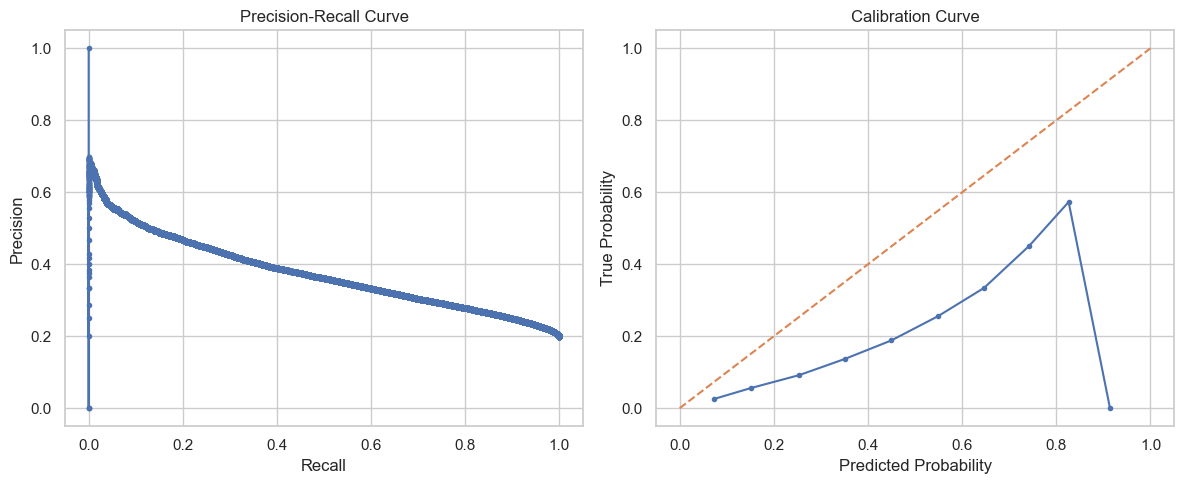

In [21]:
# PR Curve and Calibration curve
plot_pr_calib_curve(y_pred_selected, y_validation)

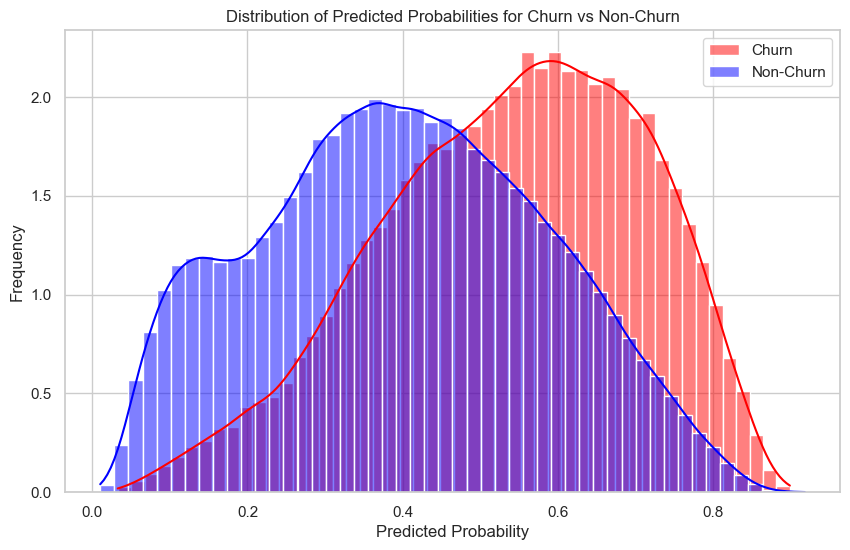

In [22]:
# Distribution of predicted probabilities
plot_dis_probs(y_pred_selected, y_validation)

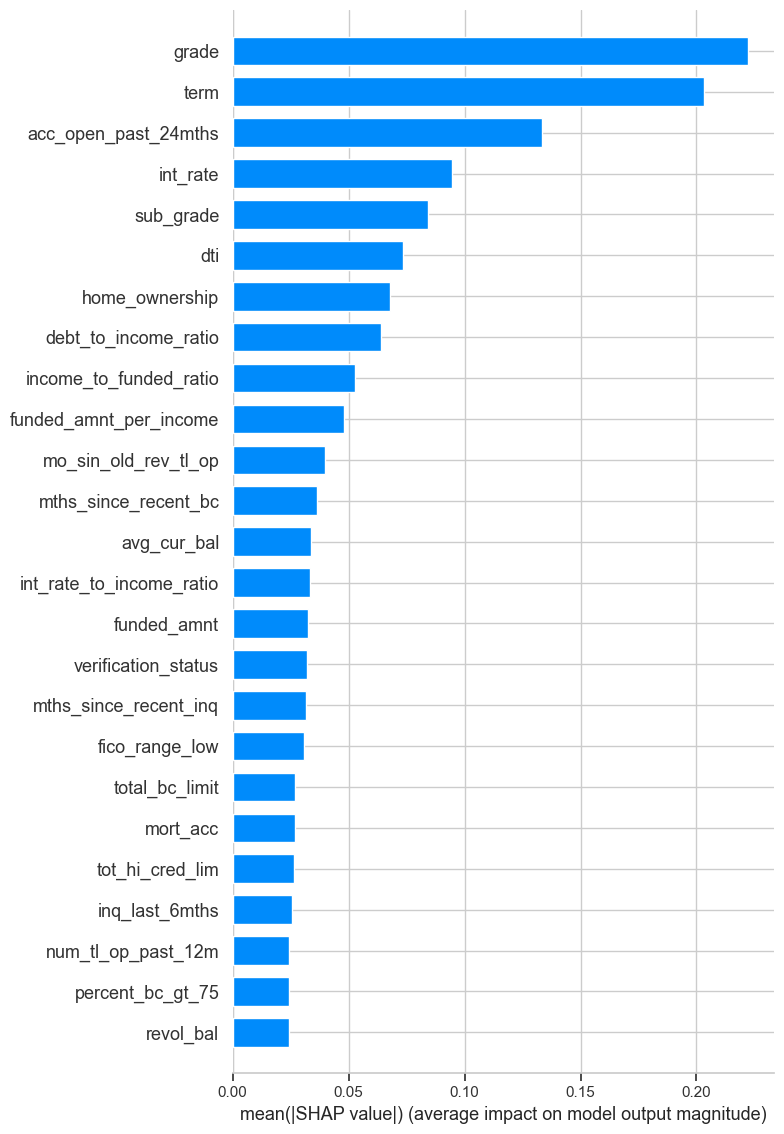

In [23]:
# SHAP Values
shape_explainer = shap.Explainer(model_selected)
shape_values = shape_explainer(X_validation[selected_features])
plot_shap_values(shape_values, X_validation[selected_features], y_validation)

## Comparing Baseline and the Feature Selected model

In [24]:
print('Baseline model')
clf_metric_report(y_pred_baseline, y_validation)
print('')

print('Feature selection model')
clf_metric_report(y_pred_selected, y_validation)
print('')

Baseline model
Evaluating the model...
ROC AUC: 0.7075410527161095
Brier Score: 0.22000429047434117
Average Precision: 0.3691383629014476
Log Loss: 0.6272075914622884

Feature selection model
Evaluating the model...
ROC AUC: 0.7108839790201789
Brier Score: 0.2026929258307413
Average Precision: 0.3740644390009613
Log Loss: 0.5875735052856713



In [25]:
print('Average precision improvement: ', (average_precision_score(y_validation, y_pred_selected) - average_precision_score(y_validation, y_pred_baseline)) / average_precision_score(y_validation, y_pred_baseline))


Average precision improvement:  0.013344795866770677


## Saving the model and artifacts

In [26]:
# Save the baseline model
baseline_model_path = '../artifacts/baseline_model.joblib'
joblib.dump(model, baseline_model_path)

# Save the model trained with selected features
feat_selection_model_path = '../artifacts/feat_selection_model.joblib'
joblib.dump(model_selected, feat_selection_model_path)

print(f"Baseline model saved to: {baseline_model_path}")
print(f"Baseline model saved to: {feat_selection_model_path}")

Baseline model saved to: ../artifacts/baseline_model.joblib
Baseline model saved to: ../artifacts/feat_selection_model.joblib
